In [51]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [52]:
df = pd.read_csv('sonar.all-data', header=None)

In [53]:
df.isna().sum().sum()

0

In [54]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='60', ylabel='count'>

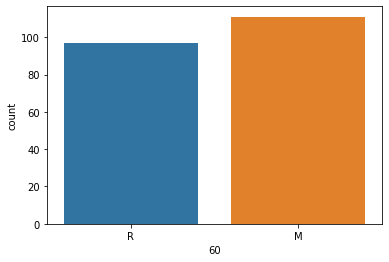

In [55]:
sns.countplot(df[60])

In [56]:
df = df.sample(frac=1)

In [57]:
df[60] = pd.factorize(df[60])[0]

In [58]:
from imblearn.over_sampling import SMOTE
def resamplingDataPrep(X_train, y_train, target_var): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class


def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [59]:
df_resample = df.copy()
y_train = df_resample.pop(60)
X_train = df_resample
X_train_sm, y_train_sm = upsample_SMOTE(X_train, y_train)
df = pd.concat([X_train_sm, y_train_sm], axis=1)

222 222


In [60]:
def to_dataloader(df, target_col, batch_size):
    target = torch.tensor(df[target_col].values.astype(np.float32))
    data = torch.tensor(df.drop(target_col, axis=1).values.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=batch_size)
    return data_loader

In [61]:
class Classifier_nn(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, activation_function):
        super(Classifier_nn, self).__init__()
        self.activation_function = activation_function
        self.fcs = nn.ModuleList()
        self.bcs = nn.ModuleList()
        self.n_layers = n_layers
        self.fcs.append(nn.Linear(input_size, hidden_size[0]))
        self.bcs.append(nn.BatchNorm1d(hidden_size[0]))
        for i in range(self.n_layers - 1):
            self.fcs.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            self.bcs.append(nn.BatchNorm1d(hidden_size[i + 1]))
        self.fcs.append(nn.Linear(hidden_size[-1], output_size))
    def forward(self, x):
        for i in range(self.n_layers):
            if i != 0:
                x = self.bcs[i](nn.Dropout(.05)(self.activation_function(self.fcs[i](x))))
            else:
                x = self.bcs[i](self.activation_function(self.fcs[i](x)))
        x = self.fcs[self.n_layers](x)
        x = x.squeeze(1)
        return x

In [62]:
def train(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    best_test_acc = -np.inf
    epochs_acc = []
    epochs_loss = []
    epochs_acc_test = []
    epochs_loss_test = []
    for epoch in tqdm(range(n_epochs), leave=False):
        for data, targets in train_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_acc_test, epoch_loss_test, _, _ = check_accuracy(model, test_loader, criterion, False)
        epoch_acc, epoch_loss, _, _ = check_accuracy(model, train_loader, criterion, False)
        epochs_acc.append(epoch_acc)
        epochs_loss.append(epoch_loss)
        epochs_acc_test.append(epoch_acc_test)
        epochs_loss_test.append(epoch_loss_test)
        if epoch_acc_test > best_test_acc:
            best_test_acc = epoch_acc_test
            torch.save(model.state_dict(), 'model.pt')
    return epochs_acc, epochs_loss, epochs_acc_test, epochs_loss_test

In [63]:
def check_accuracy(model, loader, criterion, log):
    model.eval()
    targets_agg = np.array([])
    outputs_agg = np.array([])
    with torch.no_grad():
        batches_acc = []
        batches_loss = []
        for data, targets in loader:
            targets_agg = np.append(targets_agg, targets.numpy())
            outputs = model(data)
            loss = criterion(outputs, targets)
            preds = torch.round(torch.sigmoid(outputs))
            outputs_agg = np.append(outputs_agg, preds.numpy())
            acc = (preds == targets).sum()/len(targets)
            batches_acc.append(acc.item())     
            batches_loss.append(loss.item())
    if log:
        print('accuracy: {}, loss: {}'.format(np.mean(batches_acc), np.mean(batches_loss)))
    model.train()
    return np.mean(batches_acc), np.mean(batches_loss), outputs_agg, targets_agg

In [64]:
def plot_losses(epochs_acc, epochs_loss, epochs_acc_test, epochs_loss_test, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    sns.lineplot(data=epochs_acc, label='train data', ax=axs[0])
    sns.lineplot(data=epochs_acc_test, label='test data', ax=axs[0])
    axs[0].grid()
    axs[0].set_title('Acc per epoch')
    sns.lineplot(data=epochs_loss, label='train data', ax=axs[1])
    sns.lineplot(data=epochs_loss_test, label='test data', ax=axs[1])
    axs[1].grid()
    axs[1].set_title('CrossEntropy loss per epoch')
    plt.tight_layout()

In [67]:
from sklearn.model_selection import train_test_split
def test_model(df, input_size, n_layers, hidden_size, activation_function, output_size, lr, n_epochs, batch_size):
    df = df.copy()
    y = df.pop(60)
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    train_loader = to_dataloader(
        df=train_df, 
        target_col=60, 
        batch_size=batch_size
    )
    test_loader = to_dataloader(
        df=test_df, 
        target_col=60, 
        batch_size=batch_size
    )
    model = Classifier_nn(
        input_size=input_size, 
        hidden_size=hidden_size, 
        n_layers=n_layers, 
        output_size=output_size, 
        activation_function=activation_function
    )

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    epochs_acc, epochs_loss, epochs_acc_test, epochs_loss_test = train(
        model, 
        train_loader,
        test_loader,
        criterion,
        optimizer, 
        n_epochs
    )
    plot_losses(
        epochs_acc,
        epochs_loss,
        epochs_acc_test,
        epochs_loss_test,
        'CrossEntropyLoss, and {} layers used for training'.format(str(len(hidden_size)))
    )
    model = Classifier_nn(
        input_size=input_size, 
        hidden_size=hidden_size, 
        n_layers=n_layers, 
        output_size=output_size, 
        activation_function=activation_function
    )
    model.load_state_dict(torch.load('model.pt'))
    _, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion, True)
    fig = plt.figure()
    sns.heatmap(confusion_matrix(y_true=targets_agg, y_pred=outputs_agg), annot=True)
    print(classification_report(y_pred=outputs_agg, y_true=targets_agg))

Using different number of epochs 32, 64, 128

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.90625, loss: 0.3648839667439461
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91        28
         1.0       0.90      0.93      0.91        28

    accuracy                           0.91        56
   macro avg       0.91      0.91      0.91        56
weighted avg       0.91      0.91      0.91        56



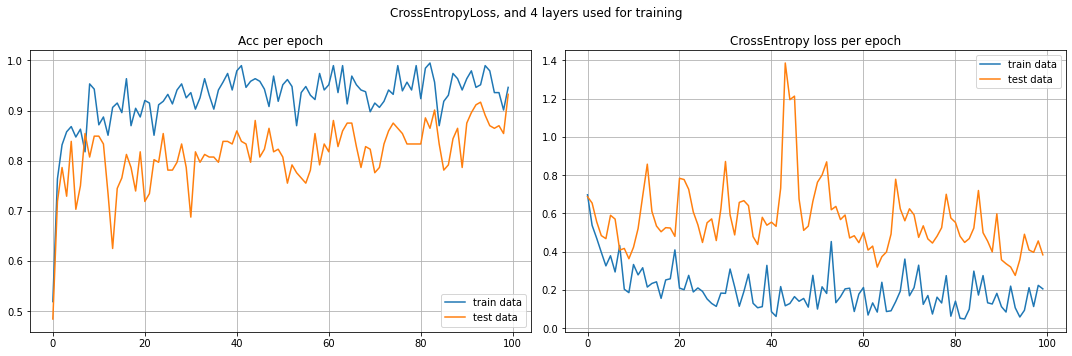

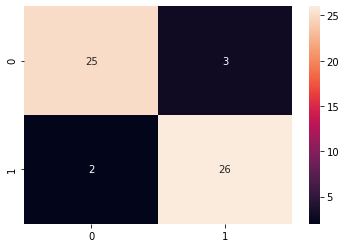

In [168]:
test_model(df, df.shape[1] - 1, 4, [70, 35, 16, 8], F.relu, 1, 0.01, 100, 32)

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.8571428656578064, loss: 0.7418203353881836
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        28
         1.0       0.86      0.86      0.86        28

    accuracy                           0.86        56
   macro avg       0.86      0.86      0.86        56
weighted avg       0.86      0.86      0.86        56



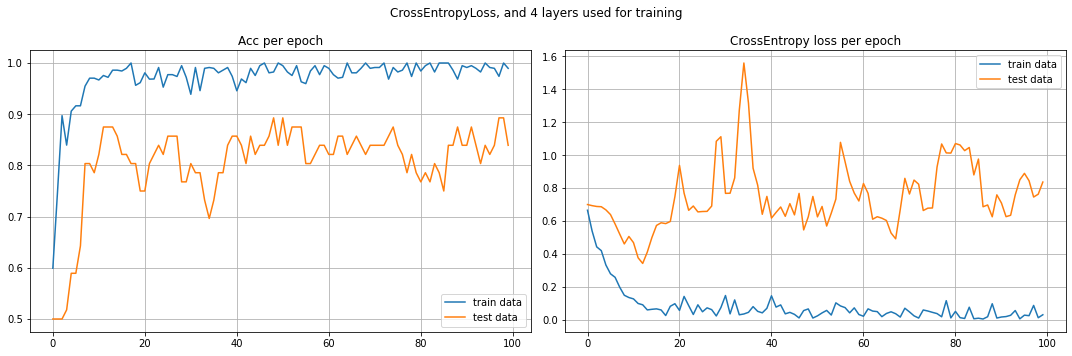

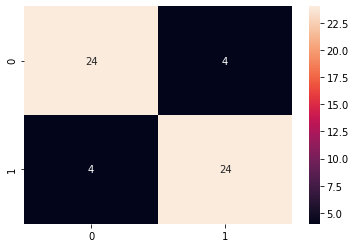

In [169]:
test_model(df, df.shape[1] - 1, 4, [70, 35, 16, 8], F.relu, 1, 0.01, 100, 64)

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.8035714030265808, loss: 0.6372475624084473
              precision    recall  f1-score   support

         0.0       0.74      0.93      0.83        28
         1.0       0.90      0.68      0.78        28

    accuracy                           0.80        56
   macro avg       0.82      0.80      0.80        56
weighted avg       0.82      0.80      0.80        56



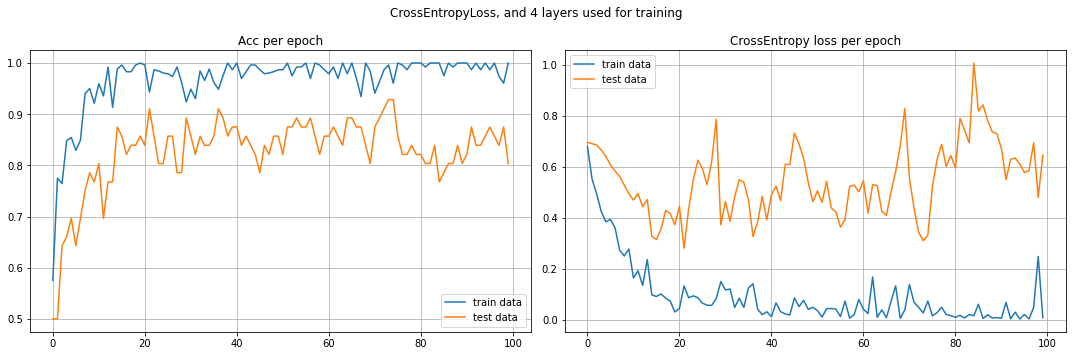

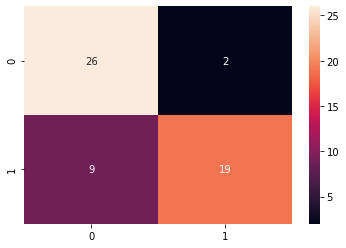

In [170]:
test_model(df, df.shape[1] - 1, 4, [70, 35, 16, 8], F.relu, 1, 0.01, 100, 128)

Using different activation function for the hidden layers

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.875, loss: 0.4286086857318878
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87        28
         1.0       0.84      0.93      0.88        28

    accuracy                           0.88        56
   macro avg       0.88      0.88      0.87        56
weighted avg       0.88      0.88      0.87        56



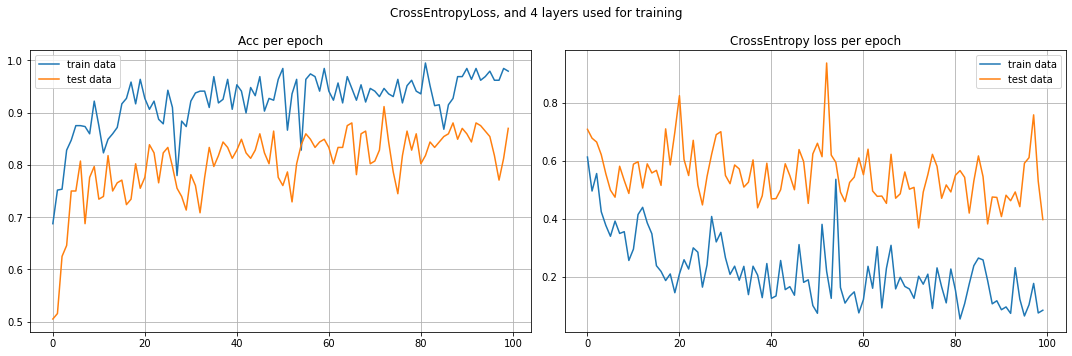

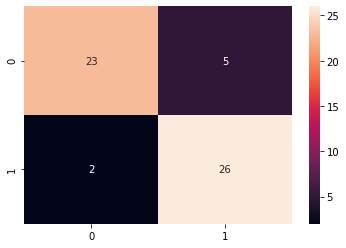

In [171]:
test_model(df, df.shape[1] - 1, 4, [70, 35, 16, 8], torch.sigmoid, 1, 0.01, 100, 32)

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.8697916567325592, loss: 0.36250656843185425
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88        28
         1.0       0.89      0.86      0.87        28

    accuracy                           0.88        56
   macro avg       0.88      0.88      0.87        56
weighted avg       0.88      0.88      0.87        56



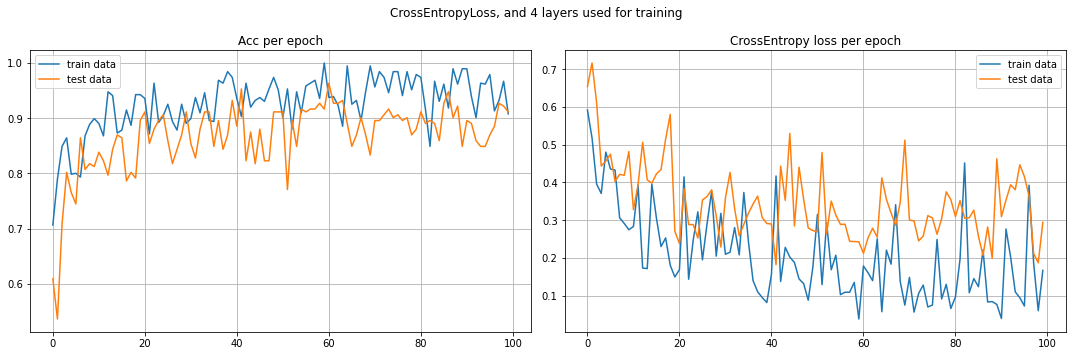

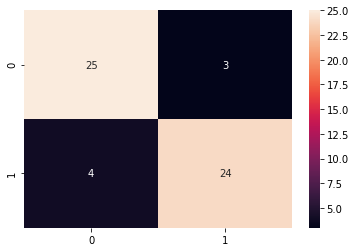

In [173]:
test_model(df, df.shape[1] - 1, 4, [70, 35, 16, 8], torch.tanh, 1, 0.01, 100, 32)

Best Model

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.9114583432674408, loss: 0.24199355393648148
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91        28
         1.0       0.93      0.89      0.91        28

    accuracy                           0.91        56
   macro avg       0.91      0.91      0.91        56
weighted avg       0.91      0.91      0.91        56



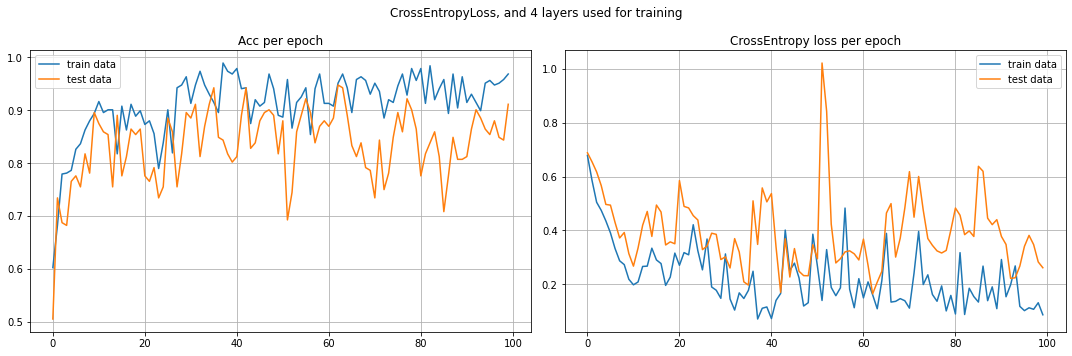

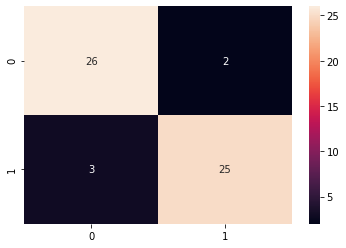

In [180]:
test_model(df, df.shape[1] - 1, 4, [70, 35, 16, 8], F.relu, 1, 0.01, 100, 32)

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.84375, loss: 0.4624003618955612
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85        28
         1.0       0.91      0.75      0.82        28

    accuracy                           0.84        56
   macro avg       0.85      0.84      0.84        56
weighted avg       0.85      0.84      0.84        56



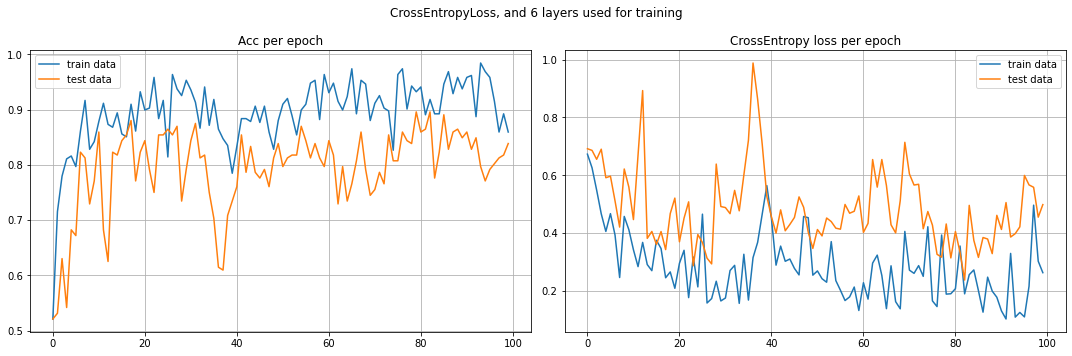

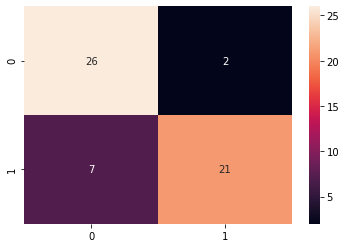

In [186]:
test_model(df, df.shape[1] - 1, 6, [70, 50, 35, 20, 10, 5], F.relu, 1, 0.01, 100, 32)

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.7291666567325592, loss: 0.6019037961959839
              precision    recall  f1-score   support

         0.0       0.70      0.82      0.75        28
         1.0       0.78      0.64      0.71        28

    accuracy                           0.73        56
   macro avg       0.74      0.73      0.73        56
weighted avg       0.74      0.73      0.73        56



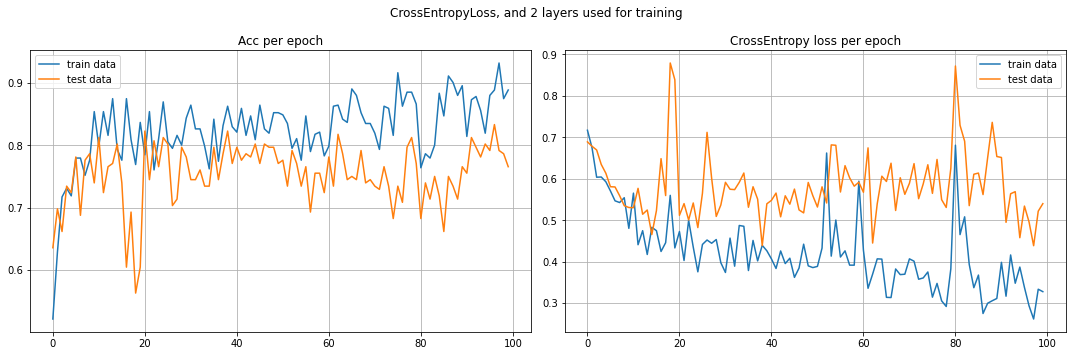

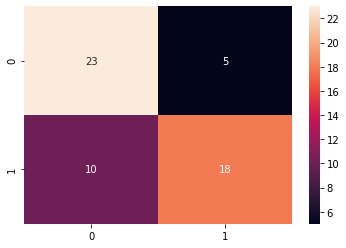

In [192]:
test_model(df, df.shape[1] - 1, 2, [2, 2], F.relu, 1, 0.01, 100, 32)